<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
Авторы материала: Павел Нестеров. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашняя работа №4
## <center> Логистическая регрессия в задаче тегирования вопросов StackOverflow

**Надо вывести формулы, где это просится (да, ручка и бумажка), заполнить код в клетках и выбрать ответы в [веб-форме](https://docs.google.com/forms/d/1I_ticU8rpeoGJjsBUcaInpvgdxdq60hV7IcSvo4rlGo/).**

## 0. Описание задачи

В этой домашней работе мы с вами изучим и запрограммируем модель для прогнозирования тегов по тексту вопроса на базе многоклассовой логистической регрессии. В отличие от обычной постановки задачи классификации (multiclass), в данном случае один пример может принадлежать одновременно к нескольким классам (multilabel). Мы будем реализовывать онлайн версию алгоритма мультиклассовой классификации.

Мы будем использовать небольшую выборку из протеггированных вопросов с сайта StackOverflow размером в 125 тысяч примеров (около 150 Мб, скачайте по [этой](https://drive.google.com/open?id=0B4bl7YMqDnViYVo0V2FubFVhMFE) ссылке).

PS: Можно показать, что такая реализация совсем не эффективная и проще было бы использовать векторизированные вычисления. Для данного датасета так и есть. Но на самом деле подобные реализации используются в жизни, но естественно, написаны они не на Python. Например, в онлайн моделях прогнозирования [CTR](https://en.wikipedia.org/wiki/Click-through_rate) юзеру показывается баннер, затем в зависимости от наличия клика происходит обновление параметров модели. В реальной жизни параметров модели может быть несколько сотен миллионов, а у юзера из этих ста миллионов от силы сто или тысяча параметров отличны от нуля, векторизировать такие вычисления не очень эффективно. Обычно все это хранится в огромных кластерах в in-memory базах данных, а обработка пользователей происходит распределенно.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
plt.rcParams['figure.figsize'] = 16, 12
from tqdm import tqdm_notebook
import pandas as pd
from collections import defaultdict
import math

# поменяйте на свой путь
DS_FILE_NAME = '../../data/stackoverflow_sample_125k.tsv'
TAGS_FILE_NAME = '../../data/top10_tags.tsv'

In [2]:
top_tags = []
with open(TAGS_FILE_NAME, 'r') as f:
    for line in f:
        top_tags.append(line.strip())
top_tags = set(top_tags)
print(top_tags)

{'ios', 'android', 'python', 'jquery', 'java', 'c++', 'c#', 'php', 'javascript', 'html'}


## 1. Многоклассовая логистическая регрессия

Вспомним, как получается логистическая регрессия для двух классов $\left\{0, 1\right\}$, вероятность принадлежности объекта к классу $1$ выписывается по теореме Байеса:

$$\large \begin{array}{rcl}
p\left(c = 1 \mid \vec{x}\right) &=& \dfrac{p\left(\vec{x} \mid c = 1\right)p\left(c = 1\right)}{p\left(\vec{x} \mid c = 1\right)p\left(c = 1\right) + p\left(\vec{x} \mid c = 0\right)p\left(c = 0\right)} \\
&=& \dfrac{1}{1 + e^{-a}} \\
&=& \sigma\left(a\right)
\end{array}$$
где:
- $\vec{x}$ – вектор признаков объекта
- $\sigma$ – обозначение функции логистического сигмоида при скалярном аргументе
- $a = \log \frac{p\left(\vec{x} \mid c = 1\right)p\left(c = 1\right)}{p\left(\vec{x} \mid c = 0\right)p\left(c = 0\right)} = \sum_{i=0}^M w_i x_i$ – это отношение мы моделируем линейной функцией от признаков объекта и параметров модели

Данное выражение легко обобщить до множества из $K$ классов, изменится только знаменатель в формуле Байеса. Запишем вероятность принадлежности объекта к классу $k$:
$$\large \begin{array}{rcl}
p\left(c = k \mid \vec{x}\right) &=& \dfrac{p\left(\vec{x} \mid c = k\right)p\left(c = k\right)}{\sum_{i=1}^K p\left(\vec{x} \mid c = i\right)p\left(c = i\right)} \\
&=& \dfrac{e^{z_k}}{\sum_{i=1}^{K}e^{z_i}} \\
&=& \sigma_k\left(\vec{z}\right)
\end{array}$$
где:
- $\sigma_k$ – обозначение функции softmax при векторном аргументе
- $z_k = \log p\left(\vec{x} \mid c = k\right)p\left(c = k\right) = \sum_{i=0}^M w_{ki} x_i$ – это выражение моделируется линейной функцией от признаков объекта и параметров модели для класса $k$

Для моделирования полного правдоподобия примера мы используем [категориальное распределение](https://en.wikipedia.org/wiki/Categorical_distribution), а лучше его логарифм (для удобства):

$$\large \begin{array}{rcl}
\mathcal{L} = \log p\left({\vec{x}}\right) &=& \log \prod_{i=1}^K \sigma_i\left(\vec{z}\right)^{y_i} \\
&=& \sum_{i=1}^K y_i \log \sigma_i\left(\vec{z}\right)
\end{array}$$

Получается хорошо знакомая нам функция [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) (если домножить на $-1$). Правдоподобие нужно максимизировать, а, соответственно, перекрестную энтропию нужно минимизировать. Продифференцировав по параметрам модели, мы _легко_ получим правила обновления весов для градиентного спуска, **проделайте этот вывод, если вы его не делали** (если вы вдруг сдались, то на [этом](https://www.youtube.com/watch?v=-WiR16raQf4) видео есть разбор вывода, понимание этого вам понадобится для дальнейшего выполнения задания):

$$\large \begin{array}{rcl}
\frac{\partial \mathcal{L}}{\partial w_{km}} &=& x_m \left(y_k - \sigma_k\left(\vec{z}\right)\right)
\end{array}$$

В стандартной формулировке получается, что вектор $\left(\sigma_1, \sigma_2, \ldots, \sigma_K\right)$ образует дискретное вероятностное распределение, т.е. $\sum_{i=1}^K \sigma_i = 1$. Но в нашей постановке задачи каждый пример может иметь несколько тегов или одновременно принадлежать к нескольким классам. Для этого мы немного изменим модель:
- будем считать, что все теги независимы друг от друга, т.е. каждый исход – это логистическая регрессия на два класса (либо есть тег, либо его нет), тогда вероятность наличия тега у примера запишется следующим образом (каждый тег/класс как и в многоклассовой логрегрессии имеет свой набор параметров):
$$\large p\left(\text{tag}_k \mid \vec{x}\right) = \sigma\left(z_k\right) = \sigma\left(\sum_{i=1}^M w_{ki} x^i \right)$$
- наличие каждого тега мы будем моделировать с помощью <a href="https://en.wikipedia.org/wiki/Bernoulli_distribution">распределения Бернулли</a>

Ваше первое задание –  записать упрощенное выражение логарифма правдоподобия примера с признаками $\vec{x}$. Как правило, многие алгоритмы оптимизации имеют интерфейс для минимизации функции, мы последуем этой же традиции, и домножим полученное выражение на $-1$, а во второй части выведем формулы для минимизации полученного выражения.

<font color="red">Варианты ответа:</font>
** Второй ответ правильный, следует из формулы распределния Бернулли + сумма берётся по К признакам, а не М фичам **

1. $\large -\mathcal{L} = -\sum_{i=1}^M y_i \log \sigma\left(z_i\right) + \left(1 - y_i\right) \log \left(1 - \sigma\left(z_i\right)\right)$
2. $\large -\mathcal{L} = -\sum_{i=1}^K y_i \log \sigma\left(z_i\right) + \left(1 - y_i\right) \log \left(1 - \sigma\left(z_i\right)\right)$
3. $\large -\mathcal{L} = -\sum_{i=1}^K z_i \log \sigma\left(y_i\right) + \left(1 - z_i\right) \log \left(1 - \sigma\left(y_i\right)\right)$
4. $\large -\mathcal{L} = -\sum_{i=1}^M z_i \log \sigma\left(y_i\right) + \left(1 - z_i\right) \log \left(1 - \sigma\left(y_i\right)\right)$

## 2. Вывод формулы обновления весов

В качестве второго задания вам предоставляется возможность вывести формулу градиента для $-\mathcal{L}$.

<font color="red">Варианты ответа:</font>:
** 2 правильный. Нужно аккуратно разложить сигмойду ** 

1. $\large -\frac{\partial \mathcal{L}}{\partial w_{km}} = -x_m \left(\sigma\left(z_k\right) - y_k\right)$
2. $\large -\frac{\partial \mathcal{L}}{\partial w_{km}} = -x_m \left(y_k - \sigma\left(z_k\right)\right)$
3. $\large -\frac{\partial \mathcal{L}}{\partial w_{km}} = \left(\sigma\left(z_k\right)x_m - y_k\right)$
4. $\large -\frac{\partial \mathcal{L}}{\partial w_{km}} = \left(y_k - \sigma\left(z_k\right)x_m\right)$

## 3. Имплементация базовой модели

Вам предлагается каркас класса модели, разберите его внимательно, обращайте внимание на комментарии. Затем заполните пропуски, запустите полученную модель и ответьте на проверочный вопрос.

Как вы могли уже заметить, при обновлении веса $w_{km}$ используется значение признака $x_m$, который равен $0$ если слова с индексом $m$ нет в предложении, и больше нуля, если такое слово есть. Соответственно, при вычислении линейной комбинации $z$ весов модели и признаков примера необходимо учитывать только ненулевые признаки объекта.

Подсказка:
- если реализовывать вычисление сигмоида так же, как в формуле, то при большом отрицательном значении $z$ вычисление $e^{-z}$ превратится в очень большое число, которое вылетит за допустимые пределы
- в то же время $e^{-z}$ от большого положительного $z$ будет нулем
- воспользуйтесь свойствами функции $\sigma$ для того, чтобы пофиксить эту ошибку

In [3]:
class LogRegressor():
    
    """Конструктор
    
    Параметры
    ----------
    tags_top : list of string, default=top_tags
        список тегов
    """
    def __init__(self, tags=top_tags):      
        # словарь который содержит мапинг слов предложений и тегов в индексы (для экономии памяти)
        # пример: self._vocab['exception'] = 17 означает что у слова exception индекс равен 17
        self._vocab = {}
        
        # параметры модели: веса
        # для каждого класса/тега нам необходимо хранить собственный вектор весов
        # по умолчанию у нас все веса будут равны нулю
        # мы заранее не знаем сколько весов нам понадобится
        # поэтому для каждого класса мы сосздаем словарь изменяемого размера со значением по умолчанию 0
        # пример: self._w['java'][self._vocab['exception']]  содержит вес для слова exception тега java
        self._w = dict([(t, defaultdict(int)) for t in tags])
        
        # параметры модели: смещения или вес w_0
        self._b = dict([(t, 0) for t in tags])
        
        self._tags = set(tags)
    
    """Один прогон по датасету
    
    Параметры
    ----------
    fname : string, default=DS_FILE_NAME
        имя файла с данными
        
    top_n_train : int
        первые top_n_train строк будут использоваться для обучения, остальные для тестирования
        
    total : int, default=10000000
        информация о количестве строк в файле для вывода прогресс бара
    
    learning_rate : float, default=0.1
        скорость обучения для градиентного спуска
        
    tolerance : float, default=1e-16
        используем для ограничения значений аргумента логарифмов
    """
    def iterate_file(self, 
                     fname=DS_FILE_NAME, 
                     top_n_train=100000, 
                     total=125000,
                     learning_rate=0.1,
                     tolerance=1e-16):
        
        self._loss = []
        n = 0
        
        # откроем файл
        with open(fname, 'r') as f:            
            
            # прогуляемся по строкам файла
            for line in tqdm_notebook(f, total=total, mininterval=1):
                pair = line.strip().split('\t')
                if len(pair) != 2:
                    continue                
                sentence, tags = pair
                # слова вопроса, это как раз признаки x
                sentence = sentence.split(' ')
                # теги вопроса, это y
                tags = set(tags.split(' '))
                
                # значение функции потерь для текущего примера
                sample_loss = 0

                # прокидываем градиенты для каждого тега
                for tag in self._tags:
                    # целевая переменная равна 1 если текущий тег есть у текущего примера
                    y = int(tag in tags)
                    
                    # расчитываем значение линейной комбинации весов и признаков объекта
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    z = self._b[tag]
   
                    for word in sentence:
                        # если в режиме тестирования появляется слово которого нет в словаре, то мы его игнорируем
                        if n >= top_n_train and word not in self._vocab:
                            continue
                        if word not in self._vocab:
                            self._vocab[word] = len(self._vocab)
                        z += self._w[tag][self._vocab[word]]
    
                    # вычисляем вероятность наличия тега
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    sigma = 1/(1 + np.exp(-z)) if z >= 0 else 1 - 1/(1 + np.exp(z))
                    #print("sigma:",sigma)
                    
                    # обновляем значение функции потерь для текущего примера
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ −∑Ki=1yilogσ(zi)+(1−yi)log(1−σ(zi))−L=−∑i=1Kyilog⁡σ(zi)+(1−yi)log⁡(1−σ(zi))
                    #print(log(sigma))
                    sample_loss += -y*np.log(np.max([tolerance, sigma])) - (1 - y)*np.log(1 - np.min([1 - tolerance, sigma]))
                        
                    #print("SecondVar:",second_var)            
                    
                    # если мы все еще в тренировочной части, то обновим параметры
                    if n < top_n_train:
                        # вычисляем производную логарифмического правдоподобия по весу
                        # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ 
                        dLdw=y-sigma
                        # делаем градиентный шаг
                        # мы минимизируем отрицательное логарифмическое правдоподобие (второй знак минус)
                        # поэтому мы идем в обратную сторону градиента для минимизации (первый знак минус)
                        for word in sentence:                            
                            self._w[tag][self._vocab[word]] -= -learning_rate*dLdw
                        self._b[tag] -= -learning_rate*dLdw
                    
                n += 1
                        
                self._loss.append(sample_loss)

In [63]:
# создадим эксемпляр модели и пройдемся по датасету
model = LogRegressor()
model.iterate_file()

Проверим, действительно ли значение отрицательного логарифмического правдоподобия уменьшалось. Так как мы используем стохастический градентный спуск, не стоит ожидать плавного падения функции ошибки. Мы воспользуемся скользящим средним с окном в 10 000 примеров, чтобы хоть как то сгладить график.

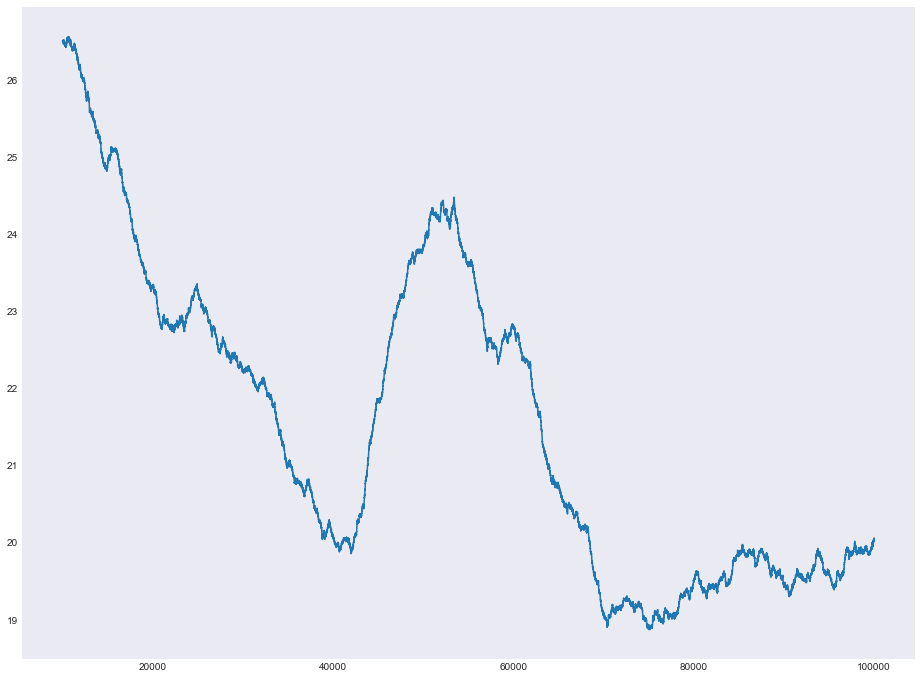

In [64]:
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean());

In [65]:
print('Mean of the loss function on the last 10k train samples: %0.2f' % np.mean(model._loss[-35000:-25000]))

Mean of the loss function on the last 10k train samples: 20.05


Вычислите среднее значение функции стоимости на последних 10 000 примеров тренировочного набора, к какому из значений ваш ответ ближе всего?

<font color="red">Варианты ответа:</font>: Третий ответ
1. 17.54
2. 18.64
3. 19.74
4. 20.84

## 4. Тестирование модели

В базовой модели первые 100 000 строк используются для обучения, а оставшиеся – для тестирования. Как вы можете заметить, значение отрицательного логарифмического правдоподобия не очень информативно, хоть и позволяет сравнивать разные модели. В качестве четвертого задания вам необходимо модифицировать базовую модель таким образом, чтобы метод `iterate_file` возвращал значение _точности_ на тестовой части набора данных. 

Точность определим следующим образом:
- считаем, что тег у вопроса присутствует, если спрогнозированная вероятность тега больше 0.9
- точность одного примера расчитывается как [коэффициент Жаккара](https://ru.wikipedia.org/wiki/Коэффициент_Жаккара) между множеством настоящих тегов и предсказанных моделью
  - например, если у примера настоящие теги ['html', 'jquery'], а по версии модели ['ios', 'html', 'java'], то коэффициент Жаккара будет равен |['html', 'jquery'] $\cap$ ['ios', 'html', 'java']| / |['html', 'jquery'] $\cup$ ['ios', 'html', 'java']| = |['html']| / |['jquery', 'ios', 'html', 'java']| = 1/4
- метод `iterate_file` возвращает **среднюю** точность на тестовом наборе данных

In [12]:
# Обновите определение класса LogRegressor
# Ваш код здесь
class LogRegressor():
    
    """Конструктор
    
    Параметры
    ----------
    tags_top : list of string, default=top_tags
        список тегов
    """
    def __init__(self, tags=top_tags):      
        # словарь который содержит мапинг слов предложений и тегов в индексы (для экономии памяти)
        # пример: self._vocab['exception'] = 17 означает что у слова exception индекс равен 17
        self._vocab = {}
        
        # параметры модели: веса
        # для каждого класса/тега нам необходимо хранить собственный вектор весов
        # по умолчанию у нас все веса будут равны нулю
        # мы заранее не знаем сколько весов нам понадобится
        # поэтому для каждого класса мы сосздаем словарь изменяемого размера со значением по умолчанию 0
        # пример: self._w['java'][self._vocab['exception']]  содержит вес для слова exception тега java
        self._w = dict([(t, defaultdict(int)) for t in tags])
        
        # параметры модели: смещения или вес w_0
        self._b = dict([(t, 0) for t in tags])
        
        self._tags = set(tags)
    
    """Один прогон по датасету
    
    Параметры
    ----------
    fname : string, default=DS_FILE_NAME
        имя файла с данными
        
    top_n_train : int
        первые top_n_train строк будут использоваться для обучения, остальные для тестирования
        
    total : int, default=10000000
        информация о количестве строк в файле для вывода прогресс бара
    
    learning_rate : float, default=0.1
        скорость обучения для градиентного спуска
        
    tolerance : float, default=1e-16
        используем для ограничения значений аргумента логарифмов
    """
    def iterate_file(self, 
                     fname=DS_FILE_NAME, 
                     top_n_train=100000, 
                     total=125000,
                     learning_rate=0.1,
                     tolerance=1e-16):
        
        self._loss = []
        mean_accuracy = 0
        n = 0
        k = 1
        
        # откроем файл
        with open(fname, 'r') as f:            
            
            # прогуляемся по строкам файла
            for line in tqdm_notebook(f, total=total, mininterval=1):
                pair = line.strip().split('\t')
                if len(pair) != 2:
                    continue                
                sentence, tags = pair
                # слова вопроса, это как раз признаки x
                sentence = sentence.split(' ')
                # теги вопроса, это y
                tags = set(tags.split(' '))
                predictedTags = set()
                # значение функции потерь для текущего примера
                sample_loss = 0

                # прокидываем градиенты для каждого тега
                for tag in self._tags:
                    # целевая переменная равна 1 если текущий тег есть у текущего примера
                    y = int(tag in tags)
                    
                    # расчитываем значение линейной комбинации весов и признаков объекта
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    z = self._b[tag]
   
                    for word in sentence:
                        # если в режиме тестирования появляется слово которого нет в словаре, то мы его игнорируем
                        if n >= top_n_train and word not in self._vocab:
                            continue
                        if word not in self._vocab:
                            self._vocab[word] = len(self._vocab)
                        z += self._w[tag][self._vocab[word]]
    
                    # вычисляем вероятность наличия тега
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    sigma = 1/(1 + np.exp(-z)) if z >= 0 else 1 - 1/(1 + np.exp(z))
                    #print("sigma:",sigma)
                    if sigma > 0.9:
                        predictedTags.add(tag)
                    
                    # обновляем значение функции потерь для текущего примера
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ −∑Ki=1yilogσ(zi)+(1−yi)log(1−σ(zi))−L=−∑i=1Kyilog⁡σ(zi)+(1−yi)log⁡(1−σ(zi))
                    #print(log(sigma))
                    sample_loss += -y*np.log(np.max([tolerance, sigma])) - (1 - y)*np.log(1 - np.min([1 - tolerance, sigma]))
                        
                    #print("SecondVar:",second_var)            
                    
                    # если мы все еще в тренировочной части, то обновим параметры
                    if n < top_n_train:
                        # вычисляем производную логарифмического правдоподобия по весу
                        # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ 
                        dLdw=y-sigma
                        # делаем градиентный шаг
                        # мы минимизируем отрицательное логарифмическое правдоподобие (второй знак минус)
                        # поэтому мы идем в обратную сторону градиента для минимизации (первый знак минус)
                        for word in sentence:                            
                            self._w[tag][self._vocab[word]] -= -learning_rate*dLdw
                        self._b[tag] -= -learning_rate*dLdw
                if n >=top_n_train:
                    line_accuracy = len(tags & predictedTags)/len(tags | predictedTags)
                    mean_accuracy = (mean_accuracy*k/(k+1)) + (line_accuracy/(k+1))
                    k += 1
                n += 1
                        
                self._loss.append(sample_loss)
                
        return mean_accuracy

In [13]:
model = LogRegressor()
acc = model.iterate_file()
# выведем полученное значение с точностью до двух знаков
print('%0.2f' % acc)


0.59


Ответьте на вопрос,  к какому значению ближе всего полученное значение точности?
<font color="red">Варианты ответа:</font>: Правильно третий вариант
1. 0.39
2. 0.49
3. 0.59
4. 0.69

## 5. $L_2$-регуляризация

В качестве пятого задания вам необходимо добавить в класс `LogRegressor` поддержку $L_2$-регуляризации. В методе `iterate_file` должен появиться параметр `lmbda=0.01` со значением по умолчанию. С учетом регуляризации новая функция стоимости примет вид:

$$\large \begin{array}{rcl}
L &=& -\mathcal{L} + \frac{\lambda}{2} R\left(W\right) \\
&=& -\mathcal{L} + \frac{\lambda}{2} \sum_{k=1}^K\sum_{i=1}^M w_{ki}^2
\end{array}$$

Градиент первого члена суммы мы уже вывели, а для второго он имеет вид:

$$\large \begin{array}{rcl}
\frac{\partial}{\partial w_{ki}} \frac{\lambda}{2} R\left(W\right) &=& \lambda w_{ki}
\end{array}$$

Если мы на каждом примере будем делать честное обновление всех весов, то все очень замедлится, ведь нам придется на каждой итерации пробегать по всем словам словаря. В ущерб теоретической точности вы используем грязный трюк: мы будем регуляризаровать только те слова, которые присутствуют в текущем предложении. Не забывайте, что смещение не регуляризируется. `sample_loss` тоже должен остаться без изменений.

In [16]:
# Обновите определение класса LogRegressor
# Ваш код здесь
class LogRegressor():
    
    """Конструктор
    
    Параметры
    ----------
    tags_top : list of string, default=top_tags
        список тегов
    """
    def __init__(self, tags=top_tags):      
        # словарь который содержит мапинг слов предложений и тегов в индексы (для экономии памяти)
        # пример: self._vocab['exception'] = 17 означает что у слова exception индекс равен 17
        self._vocab = {}
        
        # параметры модели: веса
        # для каждого класса/тега нам необходимо хранить собственный вектор весов
        # по умолчанию у нас все веса будут равны нулю
        # мы заранее не знаем сколько весов нам понадобится
        # поэтому для каждого класса мы сосздаем словарь изменяемого размера со значением по умолчанию 0
        # пример: self._w['java'][self._vocab['exception']]  содержит вес для слова exception тега java
        self._w = dict([(t, defaultdict(int)) for t in tags])
        
        # параметры модели: смещения или вес w_0
        self._b = dict([(t, 0) for t in tags])
        
        self._tags = set(tags)
    
    """Один прогон по датасету
    
    Параметры
    ----------
    fname : string, default=DS_FILE_NAME
        имя файла с данными
        
    top_n_train : int
        первые top_n_train строк будут использоваться для обучения, остальные для тестирования
        
    total : int, default=10000000
        информация о количестве строк в файле для вывода прогресс бара
    
    learning_rate : float, default=0.1
        скорость обучения для градиентного спуска
        
    tolerance : float, default=1e-16
        используем для ограничения значений аргумента логарифмов
    """
    def iterate_file(self, 
                     fname=DS_FILE_NAME, 
                     top_n_train=100000, 
                     total=125000,
                     learning_rate=0.1,
                     tolerance=1e-16,
                     lmbda=0.01):
        
        self._loss = []
        mean_accuracy = 0
        n = 0
        k = 1
        
        # откроем файл
        with open(fname, 'r') as f:            
            
            # прогуляемся по строкам файла
            for line in tqdm_notebook(f, total=total, mininterval=1):
                pair = line.strip().split('\t')
                if len(pair) != 2:
                    continue                
                sentence, tags = pair
                # слова вопроса, это как раз признаки x
                sentence = sentence.split(' ')
                # теги вопроса, это y
                tags = set(tags.split(' '))
                predictedTags = set()
                # значение функции потерь для текущего примера
                sample_loss = 0

                # прокидываем градиенты для каждого тега
                for tag in self._tags:
                    # целевая переменная равна 1 если текущий тег есть у текущего примера
                    y = int(tag in tags)
                    
                    # расчитываем значение линейной комбинации весов и признаков объекта
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    z = self._b[tag]
                    sumwk2 = 0
                    for word in sentence:
                        # если в режиме тестирования появляется слово которого нет в словаре, то мы его игнорируем
                        if n >= top_n_train and word not in self._vocab:
                            continue
                        if word not in self._vocab:
                            self._vocab[word] = len(self._vocab)
                            
                        z += self._w[tag][self._vocab[word]]
                        sumwk2 += pow(self._w[tag][self._vocab[word]],2)
    
                    # вычисляем вероятность наличия тега
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    sigma = 1/(1 + np.exp(-z)) if z >= 0 else 1 - 1/(1 + np.exp(z))
                    #print("sigma:",sigma)
                    if sigma > 0.9:
                        predictedTags.add(tag)
                    
                    # обновляем значение функции потерь для текущего примера
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ −∑Ki=1yilogσ(zi)+(1−yi)log(1−σ(zi))−L=−∑i=1Kyilog⁡σ(zi)+(1−yi)log⁡(1−σ(zi))
                    #print(log(sigma))
                    sample_loss += -y*np.log(np.max([tolerance, sigma])) - (1 - y)*np.log(1 - np.min([1 - tolerance, sigma]))
                    sample_loss += 0.5*lmbda*sumwk2
                    #print("SecondVar:",second_var)            
                    
                    # если мы все еще в тренировочной части, то обновим параметры
                    if n < top_n_train:
                        # вычисляем производную логарифмического правдоподобия по весу
                        # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ 
                        dLdw=y-sigma
                        # делаем градиентный шаг
                        # мы минимизируем отрицательное логарифмическое правдоподобие (второй знак минус)
                        # поэтому мы идем в обратную сторону градиента для минимизации (первый знак минус)
                        for word in sentence:                            
                            self._w[tag][self._vocab[word]] -= -learning_rate*(dLdw - lmbda*self._w[tag][self._vocab[word]])
                        self._b[tag] -= -learning_rate*dLdw
                if n >=top_n_train:
                    line_accuracy = len(tags & predictedTags)/len(tags | predictedTags)
                    mean_accuracy = (mean_accuracy*k/(k+1)) + (line_accuracy/(k+1))
                    k += 1
                n += 1
                        
                self._loss.append(sample_loss)
                
        return mean_accuracy


0.51


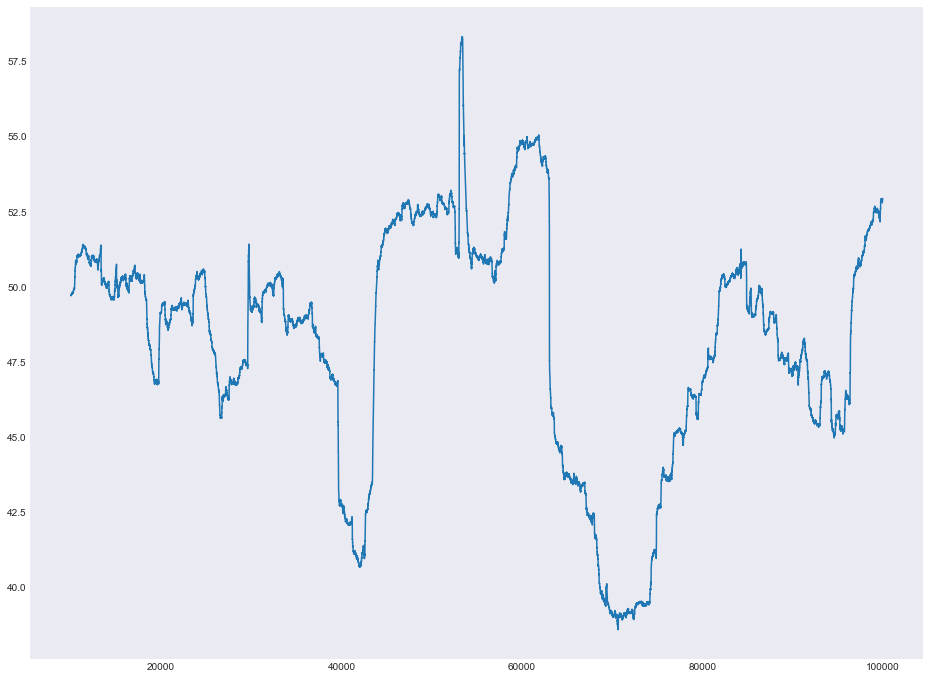

In [17]:
model = LogRegressor()
acc = model.iterate_file()
print('%0.2f' % acc)
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean());

Ответьте на вопрос, к какому значению ближе всего полученное значение точности?
<font color="red">Варианты ответа:</font>:Правильный четвёртый вариант
1. 0.3
2. 0.35
3. 0.4
4. 0.52

## 6. ElasticNet регуляризация, вывод
Помимо $L_2$ регуляризации, часто используется $L_1$ регуляризация.

$$\large \begin{array}{rcl}
L &=& -\mathcal{L} + \frac{\lambda}{2} R\left(W\right) \\
&=& -\mathcal{L} + \lambda \sum_{k=1}^K\sum_{i=1}^M \left|w_{ki}\right|
\end{array}$$

Если линейно объединить $L_1$ и $L_2$ регуляризацию, то полученный тип регуляризации называется ElasticNet:

$$\large \begin{array}{rcl}
L &=& -\mathcal{L} + \lambda R\left(W\right) \\
&=& -\mathcal{L} + \lambda \left(\gamma \sum_{k=1}^K\sum_{i=1}^M w_{ki}^2 + \left(1 - \gamma\right) \sum_{k=1}^K\sum_{i=1}^M \left|w_{ki}\right| \right)
\end{array}$$
- где $\gamma \in \left[0, 1\right]$

В качестве шестого вопроса вам предлагается вывести формулу градиента ElasticNet регуляризации (не учитывая $-\mathcal{L}$). 

<font color="red">Варианты ответа:</font>:Правильный третий вариант
1. $\large \frac{\partial}{\partial w_{ki}} \lambda R\left(W\right) = \lambda \left(2 \gamma w_{ki} + \left(1 - \gamma\right) w_{ki}\right)$ 
2. $\large \frac{\partial}{\partial w_{ki}} \lambda R\left(W\right) = \lambda \left(2 \gamma \left|w_{ki}\right| + \left(1 - \gamma\right) \text{sign}\left(w_{ki}\right)\right)$
3. $\large \frac{\partial}{\partial w_{ki}} \lambda R\left(W\right) = \lambda \left(2 \gamma w_{ki} + \left(1 - \gamma\right) \text{sign}\left(w_{ki}\right)\right)$
4. $\large \frac{\partial}{\partial w_{ki}} \lambda R\left(W\right) = \lambda \left(\gamma w_{ki} + \left(1 - \gamma\right) \text{sign}\left(w_{ki}\right)\right)$

## 7. ElasticNet регуляризация, имплементация

В качестве седьмой задачи, вам предлается изменить класс `LogRegressor` таким образом, чтобы метод `iterate_file` принимал два параметра со значениями по умолчанию `lmbda=0.0002` и `gamma=0.1`. Сделайте один проход по датасету с включенной ElasticNet регуляризацией и заданными значениями по умолчанию и ответьте на вопрос.

In [3]:
# Обновите определение класса LogRegressor
# Ваш код здесь
class LogRegressor():
    
    """Конструктор
    
    Параметры
    ----------
    tags_top : list of string, default=top_tags
        список тегов
    """
    def __init__(self, tags=top_tags):      
        # словарь который содержит мапинг слов предложений и тегов в индексы (для экономии памяти)
        # пример: self._vocab['exception'] = 17 означает что у слова exception индекс равен 17
        self._vocab = {}
        
        # параметры модели: веса
        # для каждого класса/тега нам необходимо хранить собственный вектор весов
        # по умолчанию у нас все веса будут равны нулю
        # мы заранее не знаем сколько весов нам понадобится
        # поэтому для каждого класса мы сосздаем словарь изменяемого размера со значением по умолчанию 0
        # пример: self._w['java'][self._vocab['exception']]  содержит вес для слова exception тега java
        self._w = dict([(t, defaultdict(int)) for t in tags])
        
        # параметры модели: смещения или вес w_0
        self._b = dict([(t, 0) for t in tags])
        
        self._tags = set(tags)
    
    """Один прогон по датасету
    
    Параметры
    ----------
    fname : string, default=DS_FILE_NAME
        имя файла с данными
        
    top_n_train : int
        первые top_n_train строк будут использоваться для обучения, остальные для тестирования
        
    total : int, default=10000000
        информация о количестве строк в файле для вывода прогресс бара
    
    learning_rate : float, default=0.1
        скорость обучения для градиентного спуска
        
    tolerance : float, default=1e-16
        используем для ограничения значений аргумента логарифмов
    """
    def iterate_file(self, 
                     fname=DS_FILE_NAME, 
                     top_n_train=100000, 
                     total=125000,
                     learning_rate=0.1,
                     tolerance=1e-16,
                     lmbda=0.0002,
                     gamma=0.1):
        
        self._loss = []
        mean_accuracy = 0
        n = 0
        k = 1
        
        # откроем файл
        with open(fname, 'r') as f:            
            
            # прогуляемся по строкам файла
            for line in tqdm_notebook(f, total=total, mininterval=1):
                pair = line.strip().split('\t')
                if len(pair) != 2:
                    continue                
                sentence, tags = pair
                # слова вопроса, это как раз признаки x
                sentence = sentence.split(' ')
                # теги вопроса, это y
                tags = set(tags.split(' '))
                predictedTags = set()
                # значение функции потерь для текущего примера
                sample_loss = 0

                # прокидываем градиенты для каждого тега
                for tag in self._tags:
                    # целевая переменная равна 1 если текущий тег есть у текущего примера
                    y = int(tag in tags)
                    
                    # расчитываем значение линейной комбинации весов и признаков объекта
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    z = self._b[tag]
                    sumwk2 = 0
                    sumwk = 0
                    for word in sentence:
                        # если в режиме тестирования появляется слово которого нет в словаре, то мы его игнорируем
                        if n >= top_n_train and word not in self._vocab:
                            continue
                        if word not in self._vocab:
                            self._vocab[word] = len(self._vocab)
                            
                        z += self._w[tag][self._vocab[word]]
                        sumwk2 += pow(self._w[tag][self._vocab[word]],2)
                        sumwk += abs(self._w[tag][self._vocab[word]])
    
                    # вычисляем вероятность наличия тега
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    sigma = 1/(1 + np.exp(-z)) if z >= 0 else 1 - 1/(1 + np.exp(z))
                    #print("sigma:",sigma)
                    if sigma > 0.9:
                        predictedTags.add(tag)
                    
                    # обновляем значение функции потерь для текущего примера
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ −∑Ki=1yilogσ(zi)+(1−yi)log(1−σ(zi))−L=−∑i=1Kyilog⁡σ(zi)+(1−yi)log⁡(1−σ(zi))
                    #print(log(sigma))
                    sample_loss += -y*np.log(np.max([tolerance, sigma])) - (1 - y)*np.log(1 - np.min([1 - tolerance, sigma]))
                    sample_loss += lmbda*(gamma*sumwk2 + (1-gamma)*sumwk)
                    #print("SecondVar:",second_var)       λ(γ∑Kk=1∑Mi=1w2ki+(1−γ)∑Kk=1∑Mi=1||wki||)     
                    
                    # если мы все еще в тренировочной части, то обновим параметры
                    if n < top_n_train:
                        # вычисляем производную логарифмического правдоподобия по весу
                        # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ 
                        dLdw=y-sigma
                        # делаем градиентный шаг
                        # мы минимизируем отрицательное логарифмическое правдоподобие (второй знак минус)
                        # поэтому мы идем в обратную сторону градиента для минимизации (первый знак минус)
                        for word in sentence:                            
                            self._w[tag][self._vocab[word]] -= -learning_rate*(dLdw - lmbda*(2*gamma*self._w[tag][self._vocab[word]] + (1-y)*np.sign(self._w[tag][self._vocab[word]])))
                        self._b[tag] -= -learning_rate*dLdw
                if n >=top_n_train:
                    line_accuracy = len(tags & predictedTags)/len(tags | predictedTags)
                    mean_accuracy = (mean_accuracy*k/(k+1)) + (line_accuracy/(k+1))
                    k += 1
                n += 1
                        
                self._loss.append(sample_loss)
                
        return mean_accuracy


0.56


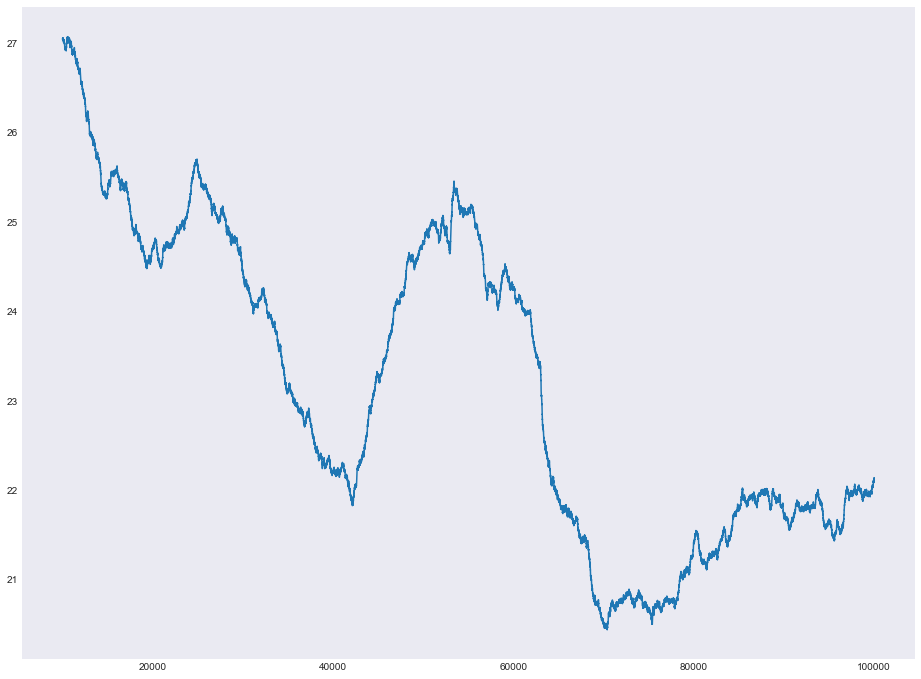

In [4]:
model = LogRegressor()
acc = model.iterate_file()
print('%0.2f' % acc)
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean());

In [20]:
print("Accuracy:",acc)

Accuracy: 0.5602349239363771


Ответьте на вопрос,  к какому значению ближе всего полученное значение точности:
<font color="red">Варианты ответа:</font>Правильный первый ответ
1. 0.59
2. 0.69
3. 0.79
4. 0.82

## 8. Самые важные слова для тега

Прелесть линейных моделей в том, что они легко интерпретируемы. Вам предлагается вычислить, какие слова вносят наибольший вклад в вероятность каждого из тегов. А затем ответьте на контрольный вопрос.

In [31]:
# Ваш код здесь
#tags_df = pd.DataFrame()
tags = model._tags
#tags_df['tags'] = list(tags)
#max(model._w['html'], key=model._w['html'].get)
#vocab = list(model._vocab)
#print(vocab[2])
for tag in tags:
    words_dictionary = model._w[tag]
    top5 = sorted(words_dictionary, key=words_dictionary.get, reverse=True)[:5]
    #top5 = dict(sorted(words_dictionary.iteritems(), key=operator.itemgetter(1), reverse=True)[:5])
    print("tag", tag)
    
    #for key, index in list(model._vocab):
    #    for top5_key in top5.items:
    #        if index == top5_key:
    #            print("TOP5 key:", key)
    
    #for index in top5:
    #    print("TOP5:", vocab[index])
    print("top5", top5)    
    print("Is tag in vocab", tag in model._vocab)
    if tag in model._vocab and model._vocab[tag] in top5:
        print("Tag: {0} in top5".format(tag))
    else:
        print("NOT")
    #top_word_index = max(model._w[tag], key=model._w[tag].get)
    #top_word = model._vocab
    
#max(model._w[list(tags)], key=model._w[list(tags)].get)
#tags_df['top_word_index'] = max(model._w[tags_df['tags']], key=model._w[tags_df['tags']].get)

tag ios
top5 [2798, 1384, 14447, 1060, 4949]
Is tag in vocab True
Tag: ios in top5
tag android
top5 [1550, 306, 20284, 15393, 512225]
Is tag in vocab True
Tag: android in top5
tag python
top5 [786, 1005, 2205, 2201, 4025]
Is tag in vocab True
Tag: python in top5
tag jquery
top5 [1639, 1570, 66, 1917, 1640]
Is tag in vocab True
Tag: jquery in top5
tag java
top5 [3991, 2519, 5345, 5344, 583]
Is tag in vocab True
Tag: java in top5
tag c++
top5 [112861, 2587, 1218, 2298, 42777]
Is tag in vocab True
Tag: c++ in top5
tag c#
top5 [20359, 491, 2611, 1661, 393]
Is tag in vocab False
NOT
tag php
top5 [742, 123228, 748, 12907, 3460]
Is tag in vocab True
Tag: php in top5
tag javascript
top5 [900, 123850, 4341, 93, 12907]
Is tag in vocab True
Tag: javascript in top5
tag html
top5 [93, 2633, 765, 235, 63]
Is tag in vocab True
Tag: html in top5


Для многих тегов наличие самого тега в предложении является важным сигналом, у многих сам тег является самым сильным сигналом, что неудивительно. Для каких из тегов само название тега не входит в топ-5 самых важных?

<font color="red">Варианты ответа:</font>Первый (но не факт)/
1. java, c#
2. php, javascript
3. html, jquery
4. ios, android

## 9. Сокращаем размер словаря
Сейчас количество слов в словаре - 519290, если бы это была выборка из 10 миллионов вопросов с сайта StackOverflow, то размер словаря был бы миллионов 10. Регуляризировать модель можно не только изящно математически, но и топорно, например, ограничить размер словаря. Вам предоставляется возможность внести следующие изменения в класс `LogRegressor`:
- добавить в метод `iterate_file` еще один аргумент со значением по умолчанию `update_vocab=True`
- при `update_vocab=True` разрешать добавлять слова в словарь в режиме обучения
- при `update_vocab=False` игнорировать слова не из словаря
- добавить в класс метод `filter_vocab(n=10000)`, который оставит в словаре только топ-n самых популярных слов

In [33]:
# Обновите определение класса LogRegressor
# Ваш код здесь
class LogRegressor():
    
    """Конструктор
    
    Параметры
    ----------
    tags_top : list of string, default=top_tags
        список тегов
    """
    def __init__(self, tags=top_tags):      
        # словарь который содержит мапинг слов предложений и тегов в индексы (для экономии памяти)
        # пример: self._vocab['exception'] = 17 означает что у слова exception индекс равен 17
        self._vocab = {}
        self._vocab_count = {}
        
        # параметры модели: веса
        # для каждого класса/тега нам необходимо хранить собственный вектор весов
        # по умолчанию у нас все веса будут равны нулю
        # мы заранее не знаем сколько весов нам понадобится
        # поэтому для каждого класса мы сосздаем словарь изменяемого размера со значением по умолчанию 0
        # пример: self._w['java'][self._vocab['exception']]  содержит вес для слова exception тега java
        self._w = dict([(t, defaultdict(int)) for t in tags])
        
        # параметры модели: смещения или вес w_0
        self._b = dict([(t, 0) for t in tags])
        
        self._tags = set(tags)
    
    """Один прогон по датасету
    
    Параметры
    ----------
    fname : string, default=DS_FILE_NAME
        имя файла с данными
        
    top_n_train : int
        первые top_n_train строк будут использоваться для обучения, остальные для тестирования
        
    total : int, default=10000000
        информация о количестве строк в файле для вывода прогресс бара
    
    learning_rate : float, default=0.1
        скорость обучения для градиентного спуска
        
    tolerance : float, default=1e-16
        используем для ограничения значений аргумента логарифмов
    """
    def filter_vocab(self,
                     n=10000):
        top_n = sorted(self._vocab_count, key=self._vocab_count.get, reverse=True)[:n]
        print("Top {0} words dictionary length: {1}".format(n,len(top_n)))
        keys_a = set(self.top_n.keys())
        keys_b = set(self._vocab.keys())
        keys = keys_a & keys_b
        temp_vocab = {}
        for key in keys:
            temp_vocab[key] = self._vocab[key]
        print("Vocabulary's length before clean:", len(self._vocab))
        self._vocab.clean()
        self._vocab_count.clean()
        self._vocab = temp_vocab
        print("Vocabulary's length after clean:", len(self._vocab))
        
    def iterate_file(self,  
                     fname=DS_FILE_NAME, 
                     top_n_train=100000, 
                     total=125000,
                     learning_rate=0.1,
                     tolerance=1e-16,
                     lmbda=0.0002,
                     gamma=0.1,
                     update_vocab=True):
        
        self._loss = []
        mean_accuracy = 0
        n = 0
        k = 1
        
        # откроем файл
        with open(fname, 'r') as f:            
            
            # прогуляемся по строкам файла
            for line in tqdm_notebook(f, total=total, mininterval=1):
                pair = line.strip().split('\t')
                if len(pair) != 2:
                    continue                
                sentence, tags = pair
                # слова вопроса, это как раз признаки x
                sentence = sentence.split(' ')
                # теги вопроса, это y
                tags = set(tags.split(' '))
                predictedTags = set()
                # значение функции потерь для текущего примера
                sample_loss = 0

                # прокидываем градиенты для каждого тега
                for tag in self._tags:
                    # целевая переменная равна 1 если текущий тег есть у текущего примера
                    y = int(tag in tags)
                    
                    # расчитываем значение линейной комбинации весов и признаков объекта
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    z = self._b[tag]
                    sumwk2 = 0
                    sumwk = 0
                    for word in sentence:
                        # если в режиме тестирования появляется слово которого нет в словаре, то мы его игнорируем
                        if n >= top_n_train and word not in self._vocab:
                            continue
                        if word not in self._vocab and update_vocab:
                            self._vocab[word] = len(self._vocab)
                            self._vocab_count[word] = 0
                        if word in self._vocab:
                            z += self._w[tag][self._vocab[word]]
                            sumwk2 += pow(self._w[tag][self._vocab[word]],2)
                            sumwk += abs(self._w[tag][self._vocab[word]])
                            self._vocab_count[word] += 1
    
                    # вычисляем вероятность наличия тега
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    sigma = 1/(1 + np.exp(-z)) if z >= 0 else 1 - 1/(1 + np.exp(z))
                    #print("sigma:",sigma)
                    if sigma > 0.9:
                        predictedTags.add(tag)
                    
                    # обновляем значение функции потерь для текущего примера
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ −∑Ki=1yilogσ(zi)+(1−yi)log(1−σ(zi))−L=−∑i=1Kyilog⁡σ(zi)+(1−yi)log⁡(1−σ(zi))
                    #print(log(sigma))
                    sample_loss += -y*np.log(np.max([tolerance, sigma])) - (1 - y)*np.log(1 - np.min([1 - tolerance, sigma]))
                    sample_loss += lmbda*(gamma*sumwk2 + (1-gamma)*sumwk)
                    #print("SecondVar:",second_var)       λ(γ∑Kk=1∑Mi=1w2ki+(1−γ)∑Kk=1∑Mi=1||wki||)     
                    
                    # если мы все еще в тренировочной части, то обновим параметры
                    if n < top_n_train:
                        # вычисляем производную логарифмического правдоподобия по весу
                        # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ 
                        dLdw=y-sigma
                        # делаем градиентный шаг
                        # мы минимизируем отрицательное логарифмическое правдоподобие (второй знак минус)
                        # поэтому мы идем в обратную сторону градиента для минимизации (первый знак минус)
                        for word in sentence:                            
                            if word in self._vocab:
                                self._w[tag][self._vocab[word]] -= -learning_rate*(dLdw - lmbda*(2*gamma*self._w[tag][self._vocab[word]] + (1-y)*np.sign(self._w[tag][self._vocab[word]])))
                        self._b[tag] -= -learning_rate*dLdw
                if n >=top_n_train:
                    line_accuracy = len(tags & predictedTags)/len(tags | predictedTags)
                    mean_accuracy = (mean_accuracy*k/(k+1)) + (line_accuracy/(k+1))
                    k += 1
                n += 1
                        
                self._loss.append(sample_loss)
                
        return mean_accuracy


0.56


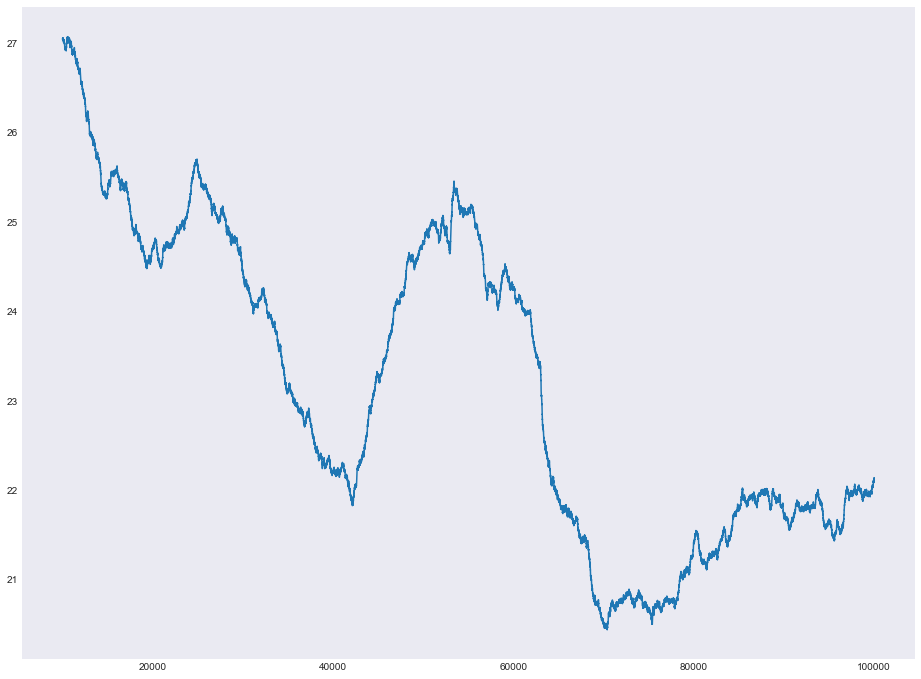

In [34]:
model = LogRegressor()
acc = model.iterate_file(update_vocab=True)
print('%0.2f' % acc)
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean());

In [35]:
# оставим только топ 10 000 слов
model.filter_vocab(n=10000)

In [39]:
a=0
b = "dff"
print("Tag:{0}, p:{1}".format(a,b))

Tag:0, p:dff


In [36]:
# сделаем еще одну итерацию по датасету, уменьшив скорость обучения в 10 раз
acc = model.iterate_file(update_vocab=False, learning_rate=0.01)
print('%0.2f' % acc)
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean());

KeyboardInterrupt: 

Ответьте на вопрос,  к какому значению ближе всего полученное значение точности:
<font color="red">Варианты ответа:</font>2 вариант ??
1. 0.48
2. 0.58
3. 0.68
4. 0.78

## 10. Прогнозирование тегов для новых вопросов

В завершение сегодняшней домашки, вам предлагается реализовать метод `predict_proba`, который принимает строку,  содержащую вопрос, а возвращает список предсказанных тегов вопроса с их вероятностями.

In [48]:
# Обновите определение класса LogRegressor
# Ваш код здесь
class LogRegressor():
    
    """Конструктор
    
    Параметры
    ----------
    tags_top : list of string, default=top_tags
        список тегов
    """
    def __init__(self, tags=top_tags):      
        # словарь который содержит мапинг слов предложений и тегов в индексы (для экономии памяти)
        # пример: self._vocab['exception'] = 17 означает что у слова exception индекс равен 17
        self._vocab = {}
        self._vocab_count = {}
        
        # параметры модели: веса
        # для каждого класса/тега нам необходимо хранить собственный вектор весов
        # по умолчанию у нас все веса будут равны нулю
        # мы заранее не знаем сколько весов нам понадобится
        # поэтому для каждого класса мы сосздаем словарь изменяемого размера со значением по умолчанию 0
        # пример: self._w['java'][self._vocab['exception']]  содержит вес для слова exception тега java
        self._w = dict([(t, defaultdict(int)) for t in tags])
        
        # параметры модели: смещения или вес w_0
        self._b = dict([(t, 0) for t in tags])
        
        self._tags = set(tags)

    def predict_proba(self,
                      question=""):
        sentence = question.split(' ')
        for tag in self._tags:
            # расчитываем значение линейной комбинации весов и признаков объекта
            # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
            z = self._b[tag]
            sumwk2 = 0
            sumwk = 0
            for word in sentence:
                # если в режиме тестирования появляется слово которого нет в словаре, то мы его игнорируем
                if word not in self._vocab:
                    continue
                if word in self._vocab:
                    z += self._w[tag][self._vocab[word]]
                    sumwk2 += pow(self._w[tag][self._vocab[word]],2)
                    sumwk += abs(self._w[tag][self._vocab[word]])
                    self._vocab_count[word] += 1

            # вычисляем вероятность наличия тега
            sigma = 1/(1 + np.exp(-z)) if z >= 0 else 1 - 1/(1 + np.exp(z))
            #print("sigma:",sigma)
            print("Tag:{0}, p:{1}".format(tag,sigma))
    
    def filter_vocab(self,
                     n=10000):
        top_n = sorted(self._vocab_count, key=self._vocab_count.get, reverse=True)[:n]
        print("Top {0} words dictionary length: {1}".format(n,len(top_n)))
        keys_a = set(top_n)
        keys_b = set(self._vocab.keys())
        keys = keys_a & keys_b
        temp_vocab = {}
        for key in keys:
            temp_vocab[key] = self._vocab[key]
        print("Vocabulary's length before clean:", len(self._vocab))
        self._vocab.clean()
        self._vocab_count.clean()
        self._vocab = temp_vocab
        print("Vocabulary's length after clean:", len(self._vocab))
        
    def iterate_file(self,  
                     fname=DS_FILE_NAME, 
                     top_n_train=100000, 
                     total=125000,
                     learning_rate=0.1,
                     tolerance=1e-16,
                     lmbda=0.0002,
                     gamma=0.1,
                     update_vocab=True):
        
        self._loss = []
        mean_accuracy = 0
        n = 0
        k = 1
        
        # откроем файл
        with open(fname, 'r') as f:            
            
            # прогуляемся по строкам файла
            for line in tqdm_notebook(f, total=total, mininterval=1):
                pair = line.strip().split('\t')
                if len(pair) != 2:
                    continue                
                sentence, tags = pair
                # слова вопроса, это как раз признаки x
                sentence = sentence.split(' ')
                # теги вопроса, это y
                tags = set(tags.split(' '))
                predictedTags = set()
                # значение функции потерь для текущего примера
                sample_loss = 0

                # прокидываем градиенты для каждого тега
                for tag in self._tags:
                    # целевая переменная равна 1 если текущий тег есть у текущего примера
                    y = int(tag in tags)
                    
                    # расчитываем значение линейной комбинации весов и признаков объекта
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    z = self._b[tag]
                    sumwk2 = 0
                    sumwk = 0
                    for word in sentence:
                        # если в режиме тестирования появляется слово которого нет в словаре, то мы его игнорируем
                        if n >= top_n_train and word not in self._vocab:
                            continue
                        if word not in self._vocab and update_vocab:
                            self._vocab[word] = len(self._vocab)
                            self._vocab_count[word] = 0
                        if word in self._vocab:
                            z += self._w[tag][self._vocab[word]]
                            sumwk2 += pow(self._w[tag][self._vocab[word]],2)
                            sumwk += abs(self._w[tag][self._vocab[word]])
                            self._vocab_count[word] += 1
    
                    # вычисляем вероятность наличия тега
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    sigma = 1/(1 + np.exp(-z)) if z >= 0 else 1 - 1/(1 + np.exp(z))
                    #print("sigma:",sigma)
                    if sigma > 0.9:
                        predictedTags.add(tag)
                    
                    # обновляем значение функции потерь для текущего примера
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ −∑Ki=1yilogσ(zi)+(1−yi)log(1−σ(zi))−L=−∑i=1Kyilog⁡σ(zi)+(1−yi)log⁡(1−σ(zi))
                    #print(log(sigma))
                    sample_loss += -y*np.log(np.max([tolerance, sigma])) - (1 - y)*np.log(1 - np.min([1 - tolerance, sigma]))
                    sample_loss += lmbda*(gamma*sumwk2 + (1-gamma)*sumwk)
                    #print("SecondVar:",second_var)       λ(γ∑Kk=1∑Mi=1w2ki+(1−γ)∑Kk=1∑Mi=1||wki||)     
                    
                    # если мы все еще в тренировочной части, то обновим параметры
                    if n < top_n_train:
                        # вычисляем производную логарифмического правдоподобия по весу
                        # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ 
                        dLdw=y-sigma
                        # делаем градиентный шаг
                        # мы минимизируем отрицательное логарифмическое правдоподобие (второй знак минус)
                        # поэтому мы идем в обратную сторону градиента для минимизации (первый знак минус)
                        for word in sentence:                            
                            if word in self._vocab:
                                self._w[tag][self._vocab[word]] -= -learning_rate*(dLdw - lmbda*(2*gamma*self._w[tag][self._vocab[word]] + (1-y)*np.sign(self._w[tag][self._vocab[word]])))
                        self._b[tag] -= -learning_rate*dLdw
                if n >=top_n_train:
                    line_accuracy = len(tags & predictedTags)/len(tags | predictedTags)
                    mean_accuracy = (mean_accuracy*k/(k+1)) + (line_accuracy/(k+1))
                    k += 1
                n += 1
                        
                self._loss.append(sample_loss)
                
        return mean_accuracy

In [49]:
model = LogRegressor()
acc = model.iterate_file(update_vocab=True)
print('%0.2f' % acc)


0.56


In [50]:
model.filter_vocab(n=10000)
acc = model.iterate_file(update_vocab=False, learning_rate=0.01)
print('%0.2f' % acc)

Top 10000 words dictionary length: 10000


AttributeError: 'list' object has no attribute 'keys'

In [53]:
sentence = ("I want to improve my coding skills, so I have planned write " +
            "a Mobile Application.need to choose between Apple's iOS or Google's Android." +
            " my background: I have done basic programming in .Net,C/C++,Python and PHP " +
            "in college, so got OOP concepts covered. about my skill level, I just know " +
            "concepts and basic syntax. But can't write complex applications, if asked :(" +
            " So decided to hone my skills, And I wanted to know which is easier to " +
            "learn for a programming n00b. A) iOS which uses Objective C B) Android " + 
            "which uses Java. I want to decide based on difficulty level")

In [54]:
model.predict_proba(sentence)

UnboundLocalError: local variable 'sentence' referenced before assignment

Ответьте на вопрос, какой или какие теги ассоциируются с данным вопросом, если порог принятия равен $0.9$?:
<font color="red">Варианты ответа:</font>
1. android
2. ios
3. ios, php
4. c#, c++, ods